In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split
import h5py
import numpy as np
import verstack
from xgboost import XGBClassifier

In [8]:
def load_data(name):
    with h5py.File(f'{name}.h5', 'r') as f:
        filename = name.split('/')[1]
        return pd.DataFrame(f[filename][:], dtype=np.float64)

train = load_data('data/train')
test = load_data('data/test')

train

,eventNumber,runNumber,actualInteractionsPerCrossing,averageInteractionsPerCrossing,correctedActualMu,correctedAverageMu,correctedScaledActualMu,correctedScaledAverageMu,NvtxReco,p_nTracks,...,p_E5x7_Lr1,p_E5x7_Lr2,p_E5x7_Lr3,p_E7x11_Lr0,p_E7x11_Lr1,p_E7x11_Lr2,p_E7x11_Lr3,p_E7x7_Lr0,p_E7x7_Lr1,index
0,87834187.0,300000.0,26.500000,26.500000,26.500000,26.500000,26.500000,26.500000,18.0,3.0,...,43402.332031,74045.820312,337.980713,273.708801,43091.683594,74447.539062,470.177124,273.708801,43091.683594,0.0
1,84862668.0,300000.0,35.500000,35.500000,35.500000,35.500000,35.500000,35.500000,23.0,4.0,...,36774.925781,58228.847656,412.321869,10861.282227,37433.324219,61805.964844,460.203613,10861.282227,37433.324219,1.0
2,20869557.0,300000.0,29.490000,29.490000,29.490000,29.490000,29.490000,29.490000,20.0,3.0,...,23413.427734,38875.042969,3492.513672,5705.863281,23728.701172,40497.234375,3333.052734,5705.863281,23728.701172,2.0
3,42161877.0,300000.0,37.500000,37.500000,37.500000,37.500000,37.500000,37.500000,17.0,2.0,...,27372.955078,104002.000000,921.178040,0.000000,27101.673828,106995.789062,1127.115356,0.000000,27101.673828,3.0
4,82761614.0,300000.0,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,33.0,7.0,...,45745.859375,87924.406250,-75.167221,0.000000,45947.109375,93710.968750,-188.182098,0.000000,45947.109375,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162495,87753440.0,300000.0,59.500000,59.500000,59.500000,59.500000,59.500000,59.500000,34.0,2.0,...,35473.875000,86889.070312,867.511475,1120.453857,36521.750000,88872.992188,748.347656,1120.453857,36521.750000,162495.0
162496,7746045.0,300000.0,11.490000,11.490000,11.490000,11.490000,11.490000,11.490000,10.0,4.0,...,36722.617188,79933.289062,352.093262,0.000000,36812.964844,83049.414062,665.589417,0.000000,36800.929688,162496.0
162497,85994391.0,300000.0,44.490002,44.490002,44.490002,44.490002,44.490002,44.490002,28.0,5.0,...,26506.359375,52808.492188,287.444580,7824.405273,26847.457031,53551.433594,-13.175649,7824.405273,26847.457031,162497.0
162498,9886827.0,300000.0,20.490000,20.490000,20.490000,20.490000,20.490000,20.490000,14.0,1.0,...,46398.742188,134187.593750,1426.328613,0.000000,46656.253906,137266.218750,1512.928101,0.000000,46656.253906,162498.0


In [3]:
all_variables = ['actualInteractionsPerCrossing', 'averageInteractionsPerCrossing', 'correctedActualMu', 'correctedAverageMu', 'correctedScaledActualMu', 'correctedScaledAverageMu', 'NvtxReco', 'p_nTracks', 'p_pt_track', 'p_eta', 'p_phi', 'p_charge', 'p_qOverP', 'p_z0', 'p_d0', 'p_sigmad0', 'p_d0Sig', 'p_EptRatio', 'p_dPOverP', 'p_z0theta', 'p_etaCluster', 'p_phiCluster', 'p_eCluster', 'p_rawEtaCluster', 'p_rawPhiCluster', 'p_rawECluster', 'p_eClusterLr0', 'p_eClusterLr1', 'p_eClusterLr2', 'p_eClusterLr3', 'p_etaClusterLr1', 'p_etaClusterLr2', 'p_phiClusterLr2', 'p_eAccCluster', 'p_f0Cluster', 'p_etaCalo', 'p_phiCalo', 'p_eTileGap3Cluster', 'p_cellIndexCluster', 'p_phiModCalo', 'p_etaModCalo', 'p_dPhiTH3', 'p_R12', 'p_fTG3', 'p_weta2', 'p_Reta', 'p_Rphi', 'p_Eratio', 'p_f1', 'p_f3', 'p_Rhad', 'p_Rhad1', 'p_deltaEta1', 'p_deltaPhiRescaled2', 'p_TRTPID', 'p_TRTTrackOccupancy', 'p_numberOfInnermostPixelHits', 'p_numberOfPixelHits', 'p_numberOfSCTHits', 'p_numberOfTRTHits', 'p_numberOfTRTXenonHits', 'p_chi2', 'p_ndof', 'p_SharedMuonTrack', 'p_E7x7_Lr2', 'p_E7x7_Lr3', 'p_E_Lr0_HiG', 'p_E_Lr0_LowG', 'p_E_Lr0_MedG', 'p_E_Lr1_HiG', 'p_E_Lr1_LowG', 'p_E_Lr1_MedG', 'p_E_Lr2_HiG', 'p_E_Lr2_LowG', 'p_E_Lr2_MedG', 'p_E_Lr3_HiG', 'p_E_Lr3_LowG', 'p_E_Lr3_MedG', 'p_ambiguityType', 'p_asy1', 'p_author', 'p_barys1', 'p_core57cellsEnergyCorrection', 'p_deltaEta0', 'p_deltaEta2', 'p_deltaEta3', 'p_deltaPhi0', 'p_deltaPhi1', 'p_deltaPhi2', 'p_deltaPhi3', 'p_deltaPhiFromLastMeasurement', 'p_deltaPhiRescaled0', 'p_deltaPhiRescaled1', 'p_deltaPhiRescaled3', 'p_e1152', 'p_e132', 'p_e235', 'p_e255', 'p_e2ts1', 'p_ecore', 'p_emins1', 'p_etconeCorrBitset', 'p_ethad', 'p_ethad1', 'p_f1core', 'p_f3core', 'p_maxEcell_energy', 'p_maxEcell_gain', 'p_maxEcell_time', 'p_maxEcell_x', 'p_maxEcell_y', 'p_maxEcell_z', 'p_nCells_Lr0_HiG', 'p_nCells_Lr0_LowG', 'p_nCells_Lr0_MedG', 'p_nCells_Lr1_HiG', 'p_nCells_Lr1_LowG', 'p_nCells_Lr1_MedG', 'p_nCells_Lr2_HiG', 'p_nCells_Lr2_LowG', 'p_nCells_Lr2_MedG', 'p_nCells_Lr3_HiG', 'p_nCells_Lr3_LowG', 'p_nCells_Lr3_MedG', 'p_pos', 'p_pos7', 'p_poscs1', 'p_poscs2', 'p_ptconeCorrBitset', 'p_ptconecoreTrackPtrCorrection', 'p_r33over37allcalo', 'p_topoetconeCorrBitset', 'p_topoetconecoreConeEnergyCorrection', 'p_topoetconecoreConeSCEnergyCorrection', 'p_weta1', 'p_widths1', 'p_widths2', 'p_wtots1', 'p_e233', 'p_e237', 'p_e277', 'p_e2tsts1', 'p_ehad1', 'p_emaxs1', 'p_fracs1', 'p_DeltaE', 'p_E3x5_Lr0', 'p_E3x5_Lr1', 'p_E3x5_Lr2', 'p_E3x5_Lr3', 'p_E5x7_Lr0', 'p_E5x7_Lr1', 'p_E5x7_Lr2', 'p_E5x7_Lr3', 'p_E7x11_Lr0', 'p_E7x11_Lr1', 'p_E7x11_Lr2', 'p_E7x11_Lr3', 'p_E7x7_Lr0', 'p_E7x7_Lr1' ]

X = train[all_variables]
y = train['Truth']


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: accuracy 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.1369451435134597
     .. Evaluation score (greater-better): accuracy: 0.9465107692307693
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.1347048038048673
     .. Evaluation score (greater-better): accuracy: 0.947076923076923
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.13782293823667754
     .. Evaluation score (greater-better): accuracy: 0.9468061538461539
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.1

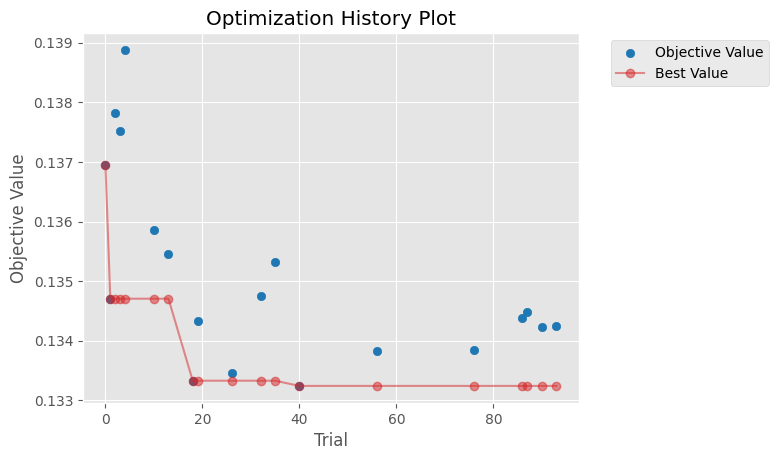

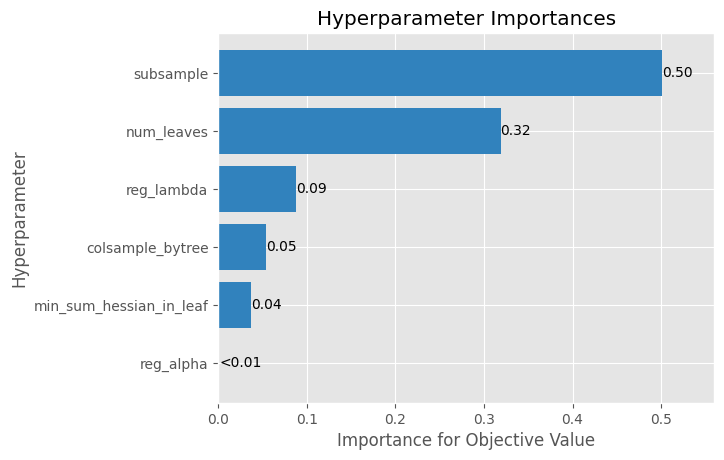

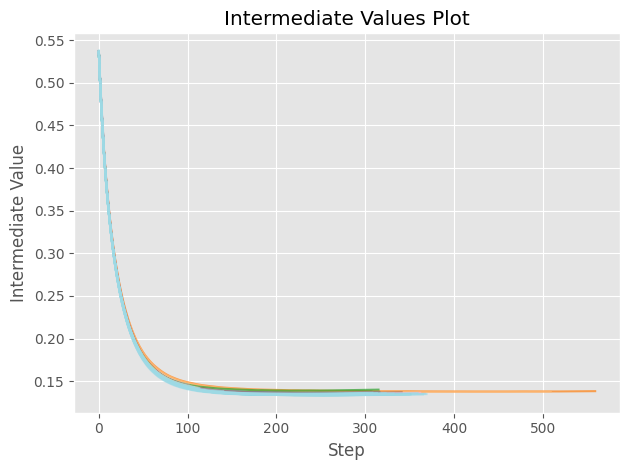

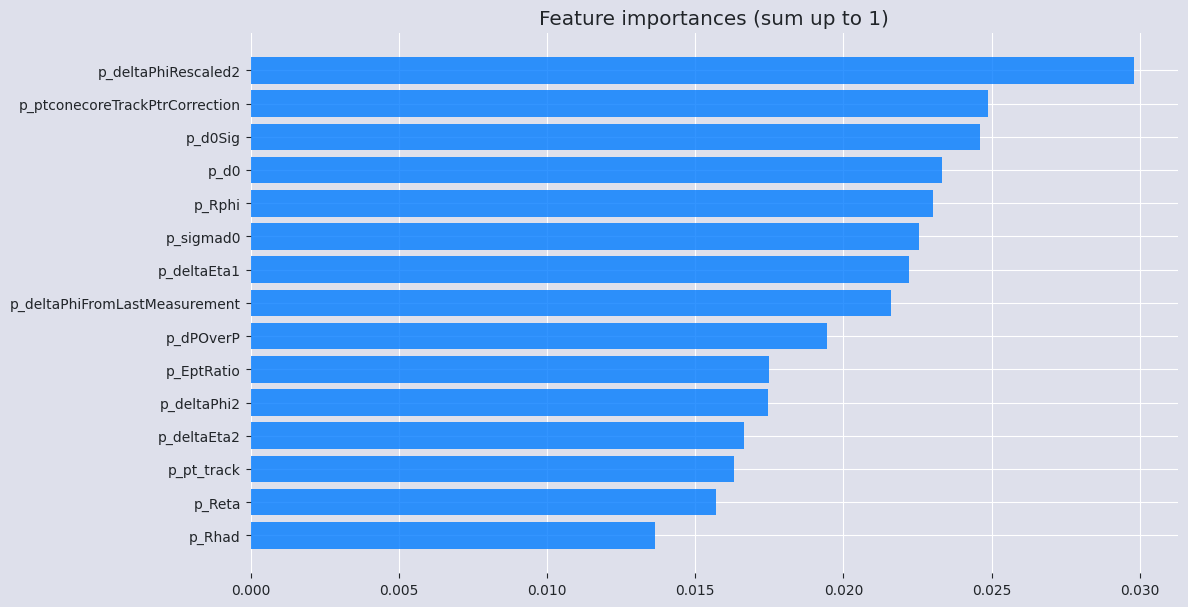


     . Optuna hyperparameters optimization finished
     .. Best trial number:40    |     log_loss:          0.13324116203536907
 ---------------------------------------------------------------------------
     . n_estimators optimization finished
     .. best iteration:  236   |     accuracy:            0.946683076923077

Time elapsed for fit execution: 7 min 18.858 sec


In [5]:
obj = verstack.LGBMTuner(metric='accuracy', visualization=True)
obj.fit(X, y)

In [10]:
obj.predict_proba(test[all_variables])

array([0.99690728, 0.97413601, 0.98807513, ..., 0.04248942, 0.00824495,
       0.99521936])

In [53]:
opt_features = list(obj.feature_importances.sort_values(ascending=False)[:15].index)
obj.feature_importances.sort_values(ascending=False)[:15]

p_deltaPhiRescaled2               0.02980
p_ptconecoreTrackPtrCorrection    0.02488
p_d0Sig                           0.02461
p_d0                              0.02331
p_Rphi                            0.02301
p_sigmad0                         0.02254
p_deltaEta1                       0.02222
p_deltaPhiFromLastMeasurement     0.02161
p_dPOverP                         0.01945
p_EptRatio                        0.01749
p_deltaPhi2                       0.01745
p_deltaEta2                       0.01666
p_pt_track                        0.01632
p_Reta                            0.01571
p_Rhad                            0.01364
dtype: float64

In [11]:
obj.best_params

{'task': 'train',
 'learning_rate': 0.04,
 'num_leaves': 189,
 'colsample_bytree': 0.5404244369317303,
 'subsample': 0.8113791779792855,
 'bagging_freq': 1,
 'max_depth': -1,
 'verbosity': -1,
 'reg_alpha': 1.1404618628653744e-05,
 'reg_lambda': 0.0664768725673448,
 'min_split_gain': 0.0,
 'zero_as_missing': False,
 'max_bin': 255,
 'min_data_in_bin': 3,
 'random_state': 42,
 'device_type': 'cpu',
 'num_classes': 1,
 'objective': 'binary',
 'metric': 'binary_logloss',
 'num_threads': 14,
 'min_sum_hessian_in_leaf': 0.0446114025293612,
 'n_estimators': 236}

## XGBoost with Optuna

In [62]:
input_train, input_valid, truth_train, truth_valid = train_test_split(X[opt_features], y, train_size=0.9, seed=42)


XGB = XGBClassifier(learning_rate=0.1, n_estimators=300, seed=42)
XGB.fit(input_train, truth_train)

XGB.score(input_valid, truth_valid)

0.9428307692307693

In [65]:
import optuna
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

def objective(trial):
    """Define the objective function"""

    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.01, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }

    # Fit the model
    optuna_model = XGBClassifier(**params)
    optuna_model.fit(input_train, truth_train)

    # Make and evaluate predictions
    accuracy = XGB.score(input_valid, truth_valid)

    return accuracy


In [66]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')

for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.9428307692307693
  Params: 
    max_depth: 3
    learning_rate: 0.014206492518143491
    n_estimators: 194
    min_child_weight: 7
    gamma: 0.025852777198985787
    subsample: 0.8047925472655003
    colsample_bytree: 0.8277514077432049
    reg_alpha: 0.00012802866331980889
    reg_lambda: 0.0011895491171799474


In [67]:
params = trial.params
model = XGBClassifier(**params)
model.fit(input_train, truth_train)

XGB.score(input_valid, truth_valid)

0.9428307692307693

## Neural Network

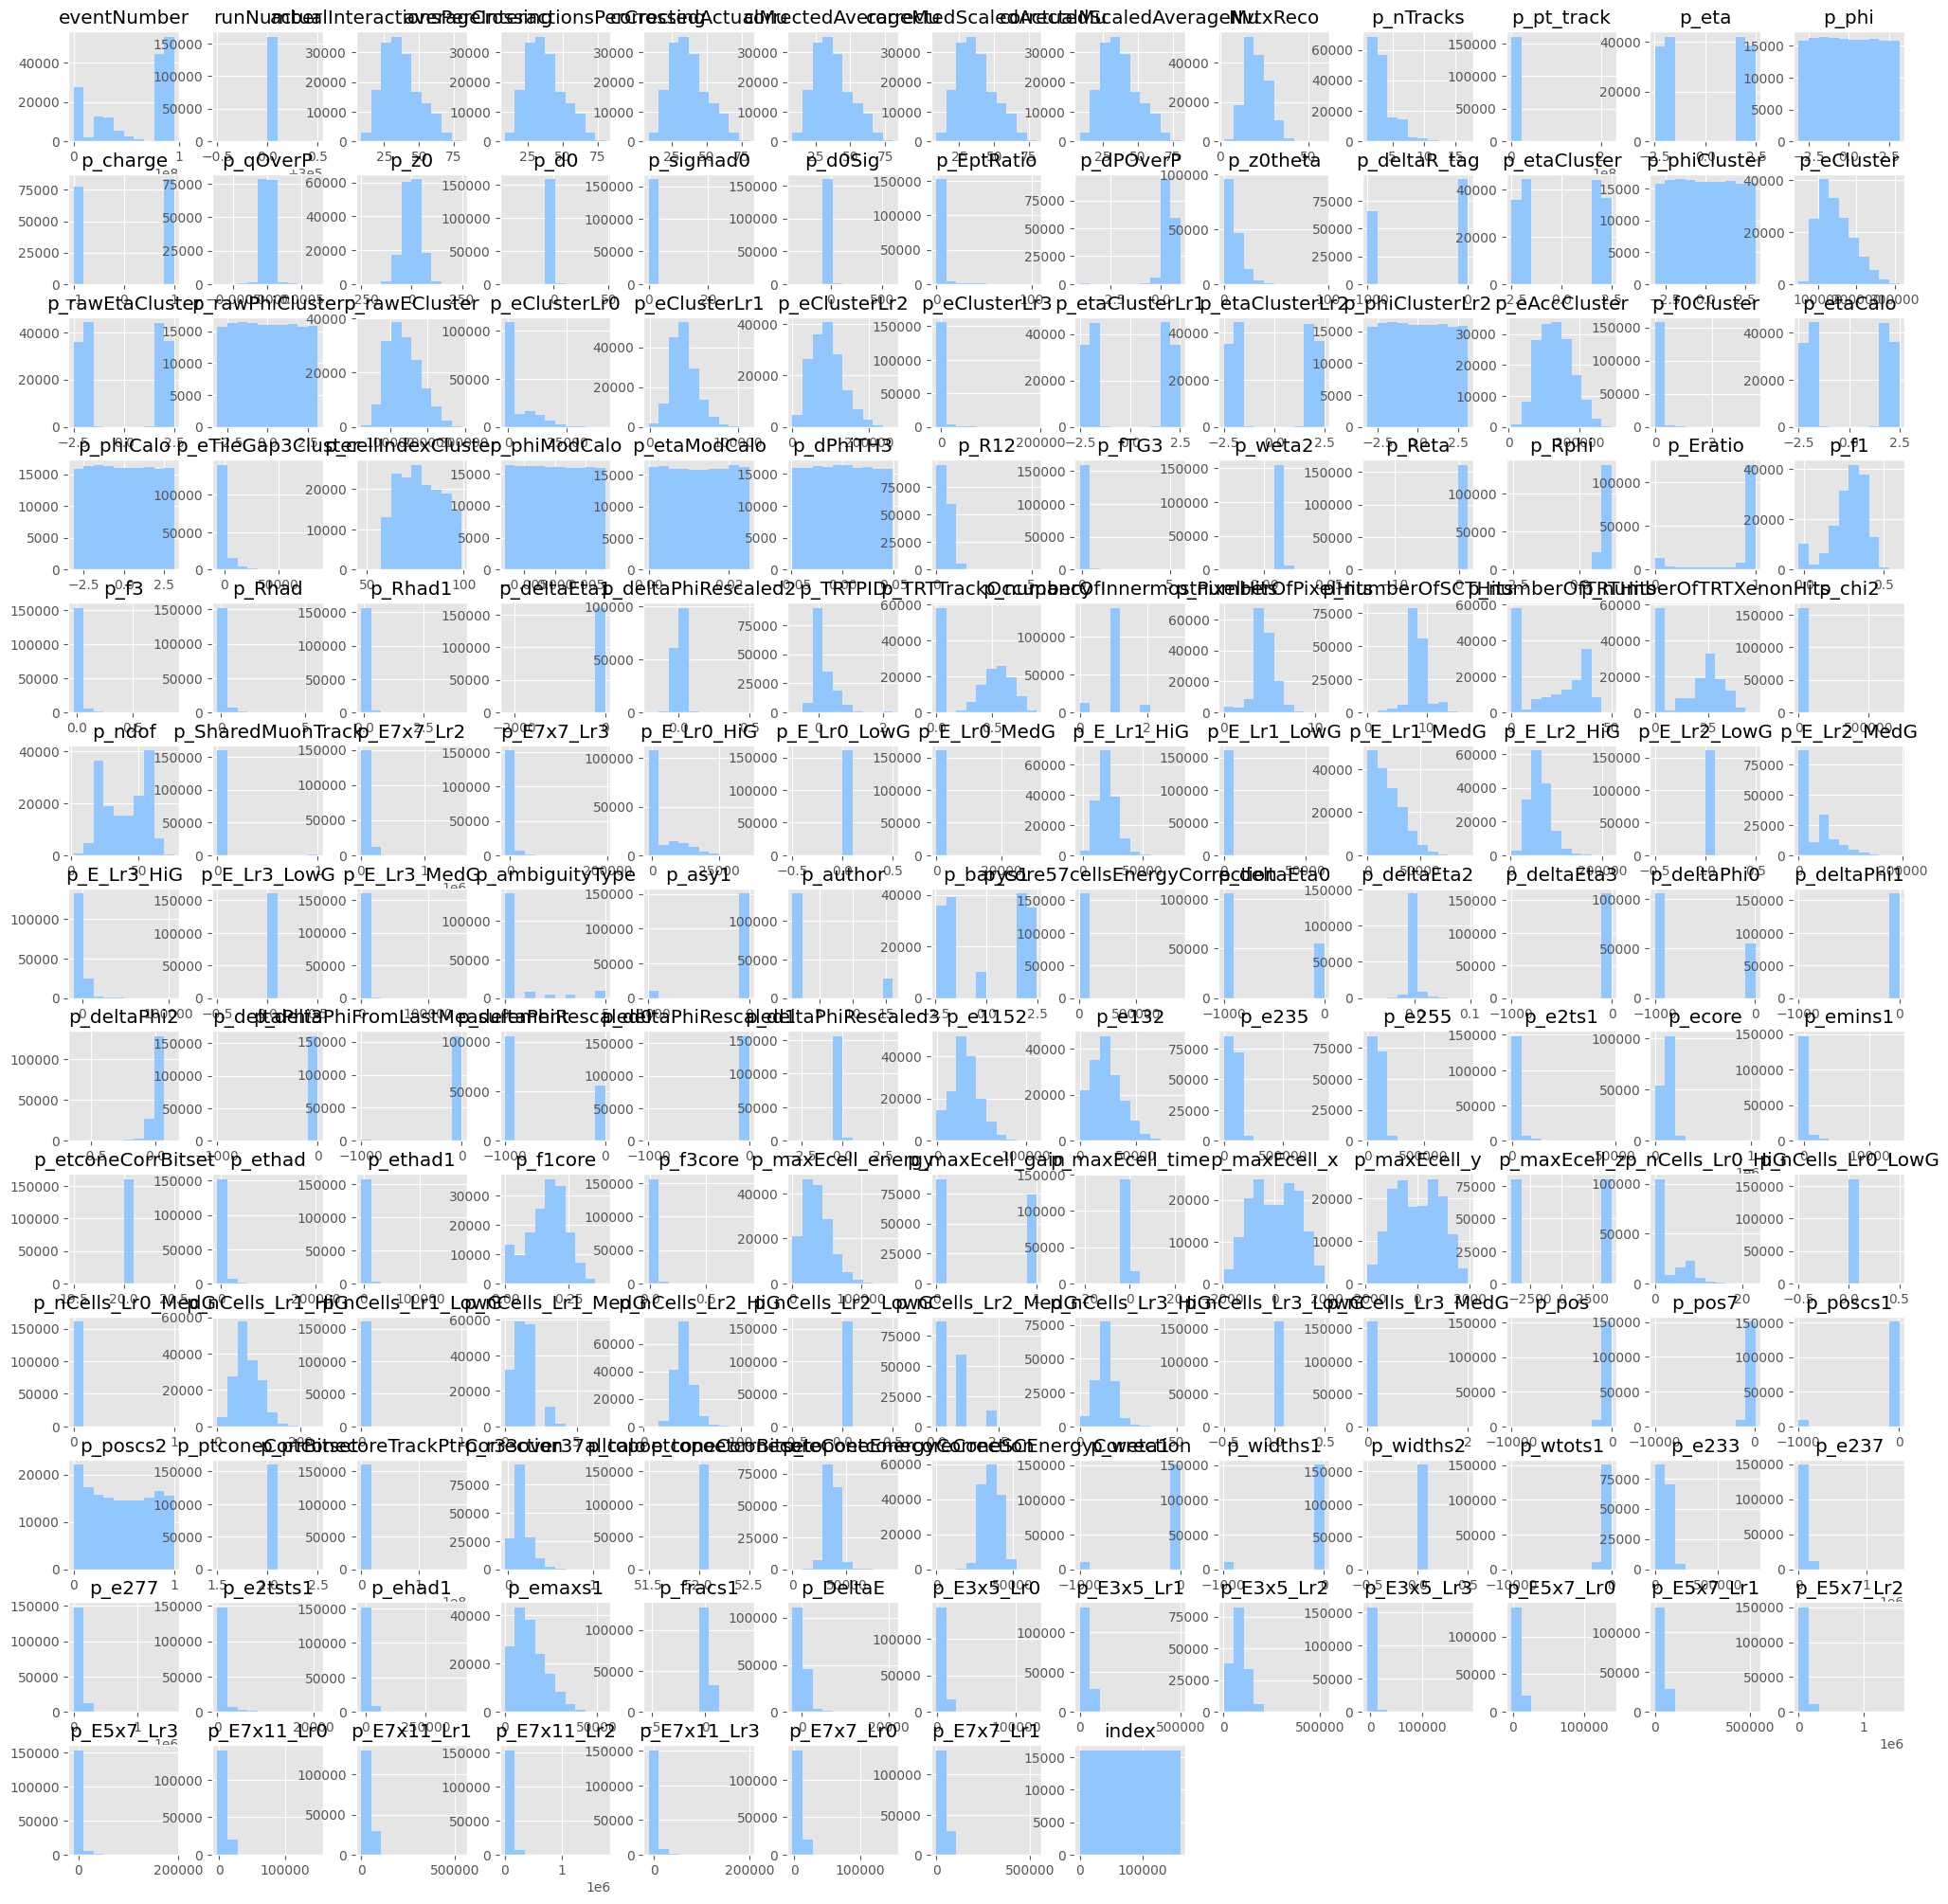

In [97]:
test.hist(figsize=[25,25]);

In [95]:
X[opt_features].describe()

,p_deltaPhiRescaled2,p_ptconecoreTrackPtrCorrection,p_d0Sig,p_d0,p_Rphi,p_sigmad0,p_deltaEta1,p_deltaPhiFromLastMeasurement,p_dPOverP,p_EptRatio,p_deltaPhi2,p_deltaEta2,p_pt_track,p_Reta,p_Rhad
count,162500.000000,1.625000e+05,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,162500.000000,1.625000e+05,162500.000000,162500.000000
mean,-0.053935,3.016883e+04,-0.070421,-0.006978,0.906449,0.043753,-0.013556,-14.555532,0.401223,3.103862,-0.011305,0.000009,3.767370e+04,0.909008,0.056030
std,8.518389,8.611457e+05,8.006779,1.018138,0.074041,0.254252,5.460531,119.636867,0.410308,6.421212,0.038727,0.006926,6.398419e+05,0.069805,0.180723
min,-1297.900879,0.000000e+00,-818.559814,-37.931423,0.000000,0.007177,-2201.196533,-999.000000,-4.000000,0.000207,-0.699607,-0.117263,3.916667e+02,-0.006000,-0.131801
25%,-0.001807,1.479927e+04,-0.804442,-0.017091,0.894428,0.015823,-0.001106,-0.015548,0.178630,1.003030,-0.007918,-0.000844,1.579378e+04,0.911298,-0.008162
50%,0.000585,2.560676e+04,0.005717,0.000111,0.933293,0.020408,-0.000047,-0.004097,0.356191,1.315141,-0.001657,-0.000014,2.871401e+04,0.930191,0.004224
75%,0.003874,3.466562e+04,0.817545,0.017175,0.949513,0.032620,0.001013,-0.000501,0.667787,2.393792,0.000547,0.000820,3.907144e+04,0.943325,0.024838
max,0.497833,3.448992e+08,592.257996,40.379303,4.815775,90.347443,0.210166,2.698916,0.999977,122.654770,0.143387,0.091991,2.347504e+08,1.342384,8.925055


In [88]:
X['p_deltaPhiRescaled2'].describe()

count    162500.000000
mean         -0.053935
std           8.518389
min       -1297.900879
25%          -0.001807
50%           0.000585
75%           0.003874
max           0.497833
Name: p_deltaPhiRescaled2, dtype: float64

In [87]:
X['p_deltaPhiRescaled2'].sort_values().head(25)

33679    -1297.900879
34869    -1297.900879
20646    -1297.900879
155143   -1297.900879
116653   -1297.900879
148007   -1297.900879
76369    -1297.900879
123736      -0.215086
6803        -0.213220
157036      -0.207897
67488       -0.206812
49141       -0.196149
137803      -0.184515
17696       -0.180961
114612      -0.178811
106078      -0.175046
37144       -0.170164
127113      -0.168639
140169      -0.168555
86985       -0.168202
90139       -0.162976
55336       -0.158422
157644      -0.156339
20296       -0.156261
8061        -0.155460
Name: p_deltaPhiRescaled2, dtype: float64

In [79]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X_transform = scalar.fit_transform(X[opt_features], y)

X_transform = pd.DataFrame(X_transform, columns=opt_features)
X_transform

,p_deltaPhiRescaled2,p_ptconecoreTrackPtrCorrection,p_d0Sig,p_d0,p_Rphi,p_sigmad0,p_deltaEta1,p_deltaPhiFromLastMeasurement,p_dPOverP,p_EptRatio,p_deltaPhi2,p_deltaEta2,p_pt_track,p_Reta,p_Rhad
0,0.006426,0.009479,-0.134149,-0.009058,0.714613,-0.116413,0.002355,0.121671,0.347367,-0.335423,0.314450,-0.079966,0.006780,0.572616,-0.568892
1,0.006213,-0.035033,-0.030214,-0.003540,-0.890548,-0.038829,0.002845,0.121227,1.249101,-0.301229,0.239895,0.240462,0.003203,0.334776,-0.377888
2,0.007730,-0.009795,0.058110,0.013914,0.355243,-0.100487,-0.000756,0.121680,-0.858713,-0.227031,0.350068,-1.108373,-0.029578,0.151158,1.095771
3,0.006419,0.002417,0.250881,0.034135,0.604344,-0.115726,0.002758,0.121668,0.932135,-0.359674,0.332537,0.027773,0.011411,0.593225,-0.206606
4,0.006834,-0.008708,0.113295,0.032800,-0.514635,-0.047909,0.002081,0.121574,-0.561015,0.015854,0.029598,0.008955,-0.041757,0.356821,-0.091531
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162495,0.006308,-0.006177,0.005695,0.006406,0.646735,-0.099811,0.002505,0.121641,0.221901,-0.326596,0.286182,0.113479,0.003521,0.264425,-0.287926
162496,0.007724,-0.023412,-0.432893,-0.238479,-0.367933,0.105709,0.002508,0.121421,-0.452487,0.602914,-0.480647,-0.114682,-0.051062,0.467257,-0.385115
162497,0.005693,0.001605,0.082503,0.014745,0.987240,-0.118545,0.002329,0.121626,0.361059,-0.335308,0.192597,0.130713,0.000093,0.613371,-0.232564
162498,-0.000383,-0.035033,0.410370,0.253203,0.610350,0.134723,-0.011399,0.119892,1.363972,1.150174,-1.588511,-5.074924,-0.053241,0.101479,-0.294926


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


# Create a NN. Loss function is BinaryCrossEntropy. Output layer has 1 node;the prediction for the rating. Learning rate defaults to 0.001. 
model = Sequential([
    Dense(len(input_train.columns),activation='relu',name='input_layer'),
    Dense(100,activation='relu',name='hidden_layer1'),
    Dense(50,activation='relu',name='hidden_layer2'),
    Dense(50,activation='relu',name='hidden_layer3'),
    Dense(1, activation='sigmoid', name='output')])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              # loss=tf.keras.losses.BinaryCrossentropy(),
              # metrics=[tf.keras.losses.BinaryCrossentropy()])
              loss=tf.keras.losses.LogCosh(),
              metrics=[tf.keras.losses.LogCosh()])

print('--------- TRAINING ---------')
history = model.fit(x = np.array(input_train), y = np.array(truth_train), validation_data=(np.array(input_valid), np.array(truth_valid)), epochs = 10)  
## This trains the model on input_train by comparing to the true values in truth_train. After every epoch of training, the model is evaluated on the validation dataset, 
## namely input_valid and truth_valid.